## Task 3. Data assimilation with more than 1 image

# 1. Imports and loading observed data

In [1]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn
from numpy.linalg import inv

from WildfirePredict.Task2.models.VAEmodel import VAE
from WildfirePredict.Task2.utils.train import create_split
from WildfirePredict.Task2.utils.predict import predict_samples, display_samples
from WildfirePredict.Task2.models.CAEmodel import CAE
import WildfirePredict.Task2.utils.assimilate as assim

In [2]:
obs_dataset = np.load("data/Ferguson_fire_obs.npy")

# 2. Loading the models from Task 1 and 2 and generating predictions

## 2.1 Task 1 Model RNN

## 2.2 Task 2 CVAE

We load the CVAE model from task 2 and generate the 5 samples we chose from the metrics.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model_path = 'data/model.pth'
model_CVAE =VAE()
model_CVAE = torch.load(model_path, map_location=torch.device('cpu'))
model_CVAE = model_CVAE.to(device)

In [6]:
#generating the a set of imamges based on the trained VAE model
samples =predict_samples(model_CVAE,1,16)

In [7]:
print(samples.shape)

(1, 1, 19, 256, 256)


In [8]:
image_indices = [10, 11, 13, 14, 17]

generated_images = samples[:, :, image_indices, :, :].reshape(len(image_indices) * samples.shape[0], 1, 256, 256)
print(generated_images.shape)

(5, 1, 256, 256)


## 3. Compressing the data

We compress the data using a CAE with a latent space dimension of (64,64).

In [10]:
#loading the compression model architecture and weights
model_CAE = CAE()
model_path ='data/CAEGroup.pth'
model_CAE.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_CAE = model_CAE.to(device)  # Ensure the model is moved to the correct device

In [11]:
# compressing the observation and model data
(encoded_sensor_data, encoded_model_data, sensors_tensor)= assim.encode_data(model_CAE, obs_dataset, generated_images, device)

In [12]:
#flatening the encoded data
num_images =encoded_sensor_data.shape[0]
latent_dim =np.prod(encoded_sensor_data.shape[2:])

flat_sensor =encoded_sensor_data.reshape(num_images, latent_dim)
flat_model =encoded_model_data.reshape(num_images, latent_dim)
encoded_shape=encoded_model_data.shape

We run the assimilation loop:

In [13]:
updated_state =assim.run_assimilation(flat_sensor, flat_model, latent_dim,encoded_shape)

Kalman Gain shape: (4096, 4096)


In [14]:
updated_state_tensor = torch.tensor(updated_state, dtype=torch.float32).to(device)
print(updated_state_tensor.shape)

torch.Size([5, 1, 64, 64])


In [15]:
with torch.no_grad():
    reconstructed_images_before = model_CAE.decoder(torch.tensor(encoded_model_data, dtype=torch.float32).to(device)).cpu().numpy()
    reconstructed_images_after = model_CAE.decoder(updated_state_tensor).cpu().numpy()
print("Reconstructed images shape:", reconstructed_images_after.shape)

Reconstructed images shape: (5, 1, 256, 256)


In [16]:
mse_latent_before = assim.mse(flat_sensor, flat_model,)
mse_latent_after = assim.mse(flat_sensor, updated_state.T.reshape(num_images, latent_dim))

print(f"MSE in latent space before assimilation: {mse_latent_before}")
print(f"MSE in latent space after assimilation: {mse_latent_after}")

# Calculate MSE in the physical space
sensors_reconstructed = sensors_tensor.cpu().numpy()

mse_physical_before = assim.mse(sensors_reconstructed, reconstructed_images_before)
mse_physical_after =assim.mse(sensors_reconstructed, reconstructed_images_after)

print(f"MSE in physical space before assimilation: {mse_physical_before}")
print(f"MSE in physical space after assimilation: {mse_physical_after}")

MSE in latent space before assimilation: 2.049832820892334
MSE in latent space after assimilation: 5.051907513319248
MSE in physical space before assimilation: 0.09212134033441544
MSE in physical space after assimilation: 0.002459259470924735


We visualise the images:

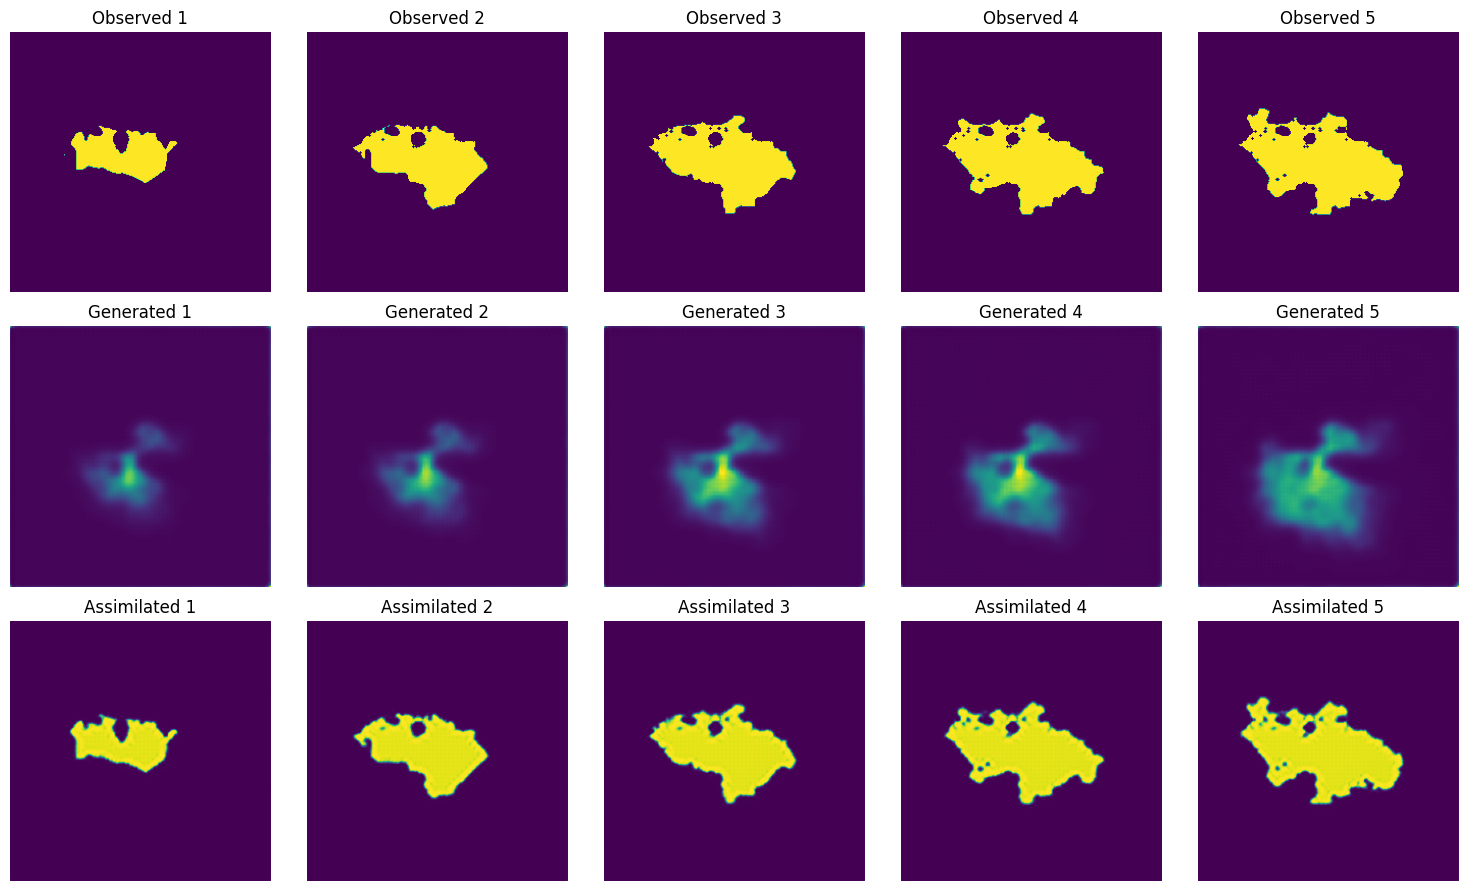

In [17]:
assim.visualise(sensors_reconstructed,reconstructed_images_before, reconstructed_images_after)